In [14]:
#using CUDA
using Test
using BenchmarkTools

using Plots
using LaTeXStrings
using Colors, ColorSchemes

cs1 = ColorScheme(range(colorant"red", colorant"royalblue1", length=5))

using QuadGK

using Base.Threads: @threads, @spawn
ENV["JULIA_NUM_THREADS"]

"64"

In [2]:
include("qts.jl")
include("brentq.jl")
include("fields.jl")

psi_s_case_E (generic function with 1 method)

In [3]:
const rho = 1.5
const gamma = 5000.0
const beta = (1-1/gamma^2)^(1/2)
lamb = 0.01/rho

#const phi_m = 0.5/rho

const phi_m = 0.1/rho  # If phi_m is large, case C wake dies

sigma_z = 50e-6
sigma_x = 50e-6

lamb_2d(z::Float64, x::Float64) = 1/(2*pi*sigma_x*sigma_z)* exp(-z^2 / 2 / sigma_z^2 - x^2 / 2 / sigma_x^2)

lamb_2d (generic function with 1 method)

In [9]:
alp_ob = 0.03

0.03

In [ ]:
Es_case_A(0.0, 0.0, gamma, alp_ob)

In [71]:
Es_case_C(0.0, 0.0, gamma, alp_ob, 0.02)

2.8943168599902743e8

# Case A

In [22]:
using Roots 

function QTS_case_A(z_ob::Float64, x_ob::Float64, gamma::Float64, phi::Float64, xp::Float64)
    
    alp_ob = phi/2
    
    ## integral    
    iii(z::Float64) =  Es_case_A((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma, alp_ob)*lamb_2d(z,xp)
    
    #println("iii(1e-8)", iii(1e-8))
    
    ## boundary conditions
    chi = ( x_ob - xp )/rho
    zi = rho*(phi - beta*sqrt(chi^2 + 4*(1 + chi)*sin(phi/2)^2))
    
    #println("xp: ", xp)
    #println("zi: ", zi)
    
#####################################
    # find critical alpha

    # These came from Es_case_D
    #N1(alp::Float64) = cos(2*alp) - (1+chi)
    #kap(alp::Float64) = sqrt(lamb^2 + chi^2 + 4*(1+chi)*sin(alp)^2 + 2*lamb*sin(2*alp))
    #N2(alp::Float64) = lamb*cos(2*alp) + (1+chi)*sin(2*alp) - beta * kap(alp)

    
    #D(alp::Float64) = 
    #println("N2(1e-9): ", N2(1E-9))
    
    return QTS_will(iii, -5*sigma_z, z_ob - zi, 6)
    
end 

QTS_case_A (generic function with 1 method)

In [23]:
QTS_case_A(0.0, 0.0, gamma, 0.1, 0.0)

5.367368475351188e11

In [14]:
QTS_case_A(0.0, 0.0, gamma, 0.1, 0.0)

5.367368475351188e11

In [6]:
function compute_Ws_case_A(z_ob::Float64, x_ob::Float64, gamma::Float64, phi::Float64, nxp::Int)
    sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(nxp-1)

    xp_vec = xp_min:dxp:xp_max
    
    #for testing only
    qvec = similar(xp_vec)  
    
    sum = 0.0
    
    for i in 1:1:length(xp_vec)
        #qvec[i] = QTS_case_A(z_ob, x_ob, gamma, phi, xp_vec[i])  # for testing
        #println("integral:", qvec[i])
        sum += QTS_case_A(z_ob, x_ob, gamma, phi, xp_vec[i])   # for CPU only
        
        
        #sum += QTS4(z_ob, x_ob, xp_vec[i])   # for CPU only
        
        # sum += QTS2(z_ob, x_ob, xp_vec[i])
        #sum +=1.0
    end
    
    #return qvec
    return sum* dxp/rho^2/gamma^2
end

compute_Ws_case_A (generic function with 1 method)

In [7]:
compute_Ws_case_A(0.0, 0.0, gamma, 0.02, 101)

1.0948814659414918e6

In [24]:
compute_Ws_case_A(0.0, 0.0, gamma, 0.02, 101)

1.0948814659414918e6

In [8]:
function Ws_case_A_multithread_phi(phi; nz=31, nx=5)
    out = zeros(Float64, nz, nx)
    z_ob = range(-5*sigma_z, 5*sigma_z, length = nz)
    x_ob = range(-2*sigma_x, 2*sigma_x, length = nx)
    @sync for i in 1:nz
        @spawn for j in 1:nx
            out[i,j] = compute_Ws_case_A(z_ob[i], x_ob[j], gamma, phi, 101)
        end
    end
    return out
end

Ws_case_A_multithread_phi (generic function with 1 method)

In [9]:
Ws_caseA_mat_phi_003 = Ws_case_A_multithread_phi(0.03, nz=101, nx=3);

In [10]:
Ws_caseA_mat_phi_004 = Ws_case_A_multithread_phi(0.04, nz=101, nx=3);

In [11]:
Ws_caseA_mat_phi_006 = Ws_case_A_multithread_phi(0.06, nz=101, nx=3);

In [12]:
Ws_caseA_mat_phi_008 = Ws_case_A_multithread_phi(0.08, nz=101, nx=3);

In [13]:
Ws_caseA_mat_phi_01 = Ws_case_A_multithread_phi(0.1, nz=101, nx=3);

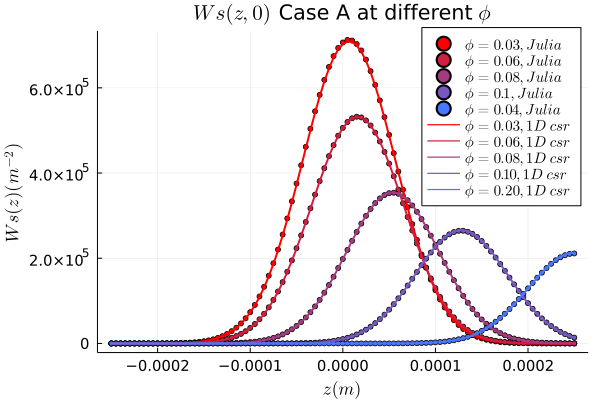

In [21]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)

plot(z_ob, Ws_caseA_mat_phi_003[102:202], label=L"\phi=0.03, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Ws_caseA_mat_phi_004[102:202], label=L"\phi=0.06, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(z_ob, Ws_caseA_mat_phi_006[102:202], label=L"\phi=0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(z_ob, Ws_caseA_mat_phi_008[102:202], label=L"\phi=0.1, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(z_ob, Ws_caseA_mat_phi_01[102:202], label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])

plot!(z_ob, WsA_int_vec_1, linewidth=2, label=L"\phi=0.03, 1D~ csr", color=cs1[1])
plot!(z_ob, WsA_int_vec_2, linewidth=2, label=L"\phi=0.06, 1D~ csr", color=cs1[2])
plot!(z_ob, WsA_int_vec_3, linewidth=2, label=L"\phi=0.08, 1D~ csr", color=cs1[3])
plot!(z_ob, WsA_int_vec_4, linewidth=2, label=L"\phi=0.10, 1D~ csr", color=cs1[4])
plot!(z_ob, WsA_int_vec_5, linewidth=2, label=L"\phi=0.20, 1D~ csr", color=cs1[5])


plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ Case A at different $\phi$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=1Plots.mm, legend=(0.75, 0.96), legendfontsize = 10)

# Case C

In [25]:
#using Roots 

function QTS_case_C(z_ob::Float64, x_ob::Float64, gamma::Float64, phi_m::Float64, lamb::Float64, xp::Float64)
    
    alp_ob = phi_m/2
    
    ## integral    
    iii(z::Float64) =  Es_case_C((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma, alp_ob, lamb)*lamb_2d(z,xp)
    
    #println("iii(1e-8)", iii(1e-8))
    
    ## boundary conditions
    chi = ( x_ob - xp )/rho
    zid = rho*(phi_m + lamb - beta*sqrt(lamb^2 + chi^2 + 4*(1 + chi)*sin(phi_m/2)^2 + 2*lamb*sin(phi_m)))
    
    
    #println("xp: ", xp)
    #println("zi: ", zi)
    
    return QTS_will(iii, -5*sigma_z, z_ob - zid, 6)
    
end

QTS_case_C (generic function with 1 method)

In [77]:
QTS_case_A(0.0, 0.0, gamma, 0.1, 0.0)

5.367368475351188e11

In [81]:
QTS_case_C(0.0, 0.0, gamma, 0.1, 0.0, 0.0)

5.367368475351188e11

In [27]:
function compute_Ws_case_C(z_ob::Float64, x_ob::Float64, gamma::Float64, phi_m::Float64, lamb::Float64, nxp::Int)
    sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(nxp-1)

    xp_vec = xp_min:dxp:xp_max
    
    #for testing only
    qvec = similar(xp_vec)  
    
    sum = 0.0
    
    for i in 1:1:length(xp_vec)
        #qvec[i] = QTS_case_C(z_ob, x_ob, gamma, phi, xp_vec[i])  # for testing
        #println("integral:", qvec[i])
        sum += QTS_case_C(z_ob, x_ob, gamma, phi_m, lamb, xp_vec[i])   # for CPU only
        
        
        #sum += QTS4(z_ob, x_ob, xp_vec[i])   # for CPU only
        
        # sum += QTS2(z_ob, x_ob, xp_vec[i])
        #sum +=1.0
    end
    
    #return qvec
    return sum* dxp/rho^2/gamma^2
end

compute_Ws_case_C (generic function with 1 method)

In [84]:
compute_Ws_case_A(0.0, 0.0, gamma, 0.02,  101)

1.0948814659414918e6

In [28]:
compute_Ws_case_C(0.0, 0.0, gamma, 0.02, 0.0, 101)

1.0948814659414918e6

In [29]:
function Ws_case_C_multithread_lamb(lamb; nz=31, nx=5)
    out = zeros(Float64, nz, nx)
    z_ob = range(-5*sigma_z, 5*sigma_z, length = nz)
    x_ob = range(-2*sigma_x, 2*sigma_x, length = nx)
    @sync for i in 1:nz
        @spawn for j in 1:nx
            out[i,j] = compute_Ws_case_C(z_ob[i], x_ob[j], gamma, phi_m, lamb, 101)
        end
    end
    return out
end

Ws_case_C_multithread_lamb (generic function with 1 method)

In [30]:
Ws_caseC_mat_lamb_001 = Ws_case_C_multithread_lamb(0.01, nz=101, nx=3);

In [31]:
Ws_caseC_mat_lamb_002 = Ws_case_C_multithread_lamb(0.02, nz=101, nx=3);

In [32]:
Ws_caseC_mat_lamb_003 = Ws_case_C_multithread_lamb(0.03, nz=101, nx=3);

In [33]:
Ws_caseC_mat_lamb_004 = Ws_case_C_multithread_lamb(0.04, nz=101, nx=3);

In [34]:
Ws_caseC_mat_lamb_005 = Ws_case_C_multithread_lamb(0.05, nz=101, nx=3);

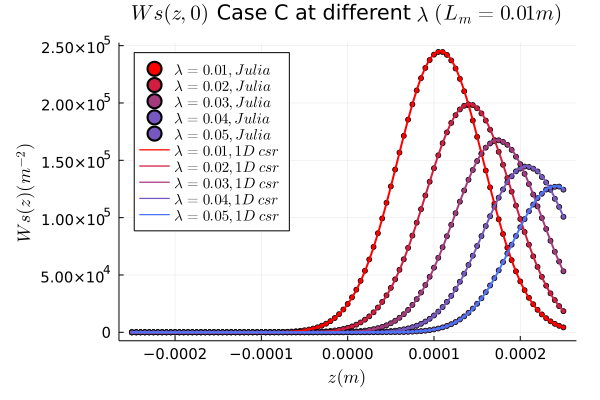

In [35]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
plot(z_ob, Ws_caseC_mat_lamb_001[102:202], label=L"\lambda=0.01, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Ws_caseC_mat_lamb_002[102:202], label=L"\lambda=0.02, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(z_ob, Ws_caseC_mat_lamb_003[102:202], label=L"\lambda=0.03, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(z_ob, Ws_caseC_mat_lamb_004[102:202], label=L"\lambda=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(z_ob, Ws_caseC_mat_lamb_005[102:202], label=L"\lambda=0.05, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])


plot!(z_ob, WsC_int_vec_1, linewidth=2, label=L"\lambda=0.01, 1D~ csr", color=cs1[1])
plot!(z_ob, WsC_int_vec_2, linewidth=2, label=L"\lambda=0.02, 1D~ csr", color=cs1[2])
plot!(z_ob, WsC_int_vec_3, linewidth=2, label=L"\lambda=0.03, 1D~ csr", color=cs1[3])
plot!(z_ob, WsC_int_vec_4, linewidth=2, label=L"\lambda=0.04, 1D~ csr", color=cs1[4])
plot!(z_ob, WsC_int_vec_5, linewidth=2, label=L"\lambda=0.05, 1D~ csr", color=cs1[5])

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ Case C at different $\lambda$ $(L_m=0.01m)$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:topleft, legendfontsize = 10)

# 1D theory

In [16]:
lamb_1d(z::Float64) = 1/(sigma_z*sqrt(2*pi))* exp(-z^2 / 2 / sigma_z^2)
lamb_1d_prime(z::Float64) = 1/(sigma_z*sqrt(2*pi))* exp(-z^2 / 2 / sigma_z^2) * (-z / sigma_z^2)

# Case A Ws
function Ws_case_A_1D_theory(z_ob::Float64, phi::Float64)
    #alternative form
    return 4/phi/rho * lamb_1d( z_ob - rho*phi^3/6 )
end

# Case C Ws
function Ws_case_C_1D_theory(z_ob::Float64, phi_m::Float64, lamb::Float64)
    #alternative form
    return 4/rho/(phi_m + 2*lamb) * lamb_1d( z_ob - rho*phi_m^2*(phi_m+3*lamb)/6 )
end

Ws_case_C_1D_theory (generic function with 1 method)

In [17]:
phi = 0.02
WsA_1D(z_ob::Float64) = Ws_case_A_1D_theory(z_ob, phi)
WsA_1D(0.0)

WsC_1D(z_ob::Float64) = Ws_case_C_1D_theory(z_ob, phi_m, lamb)
WsC_1D(0.0)

41627.30414454468

In [8]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)

-0.00025:5.0e-6:0.00025

In [18]:
phi_vec = [0.03, 0.04, 0.06, 0.08, 0.1];
phi = phi_vec[1]
WsA_int_vec_1 = map(WsA_1D, z_ob);
phi = phi_vec[2]
WsA_int_vec_2 = map(WsA_1D, z_ob);
phi = phi_vec[3]
WsA_int_vec_3 = map(WsA_1D, z_ob);
phi = phi_vec[4]
WsA_int_vec_4 = map(WsA_1D, z_ob);
phi = phi_vec[5]
WsA_int_vec_5 = map(WsA_1D, z_ob);

In [19]:
lamb_vec = [0.01, 0.02, 0.03, 0.04, 0.05];
lamb = lamb_vec[1]
WsC_int_vec_1 = map(WsC_1D, z_ob);
lamb = lamb_vec[2]
WsC_int_vec_2 = map(WsC_1D, z_ob);
lamb = lamb_vec[3]
WsC_int_vec_3 = map(WsC_1D, z_ob);
lamb = lamb_vec[4]
WsC_int_vec_4 = map(WsC_1D, z_ob);
lamb = lamb_vec[5]
WsC_int_vec_5 = map(WsC_1D, z_ob);